# Prediction of hardness based on chemical formula and load (state)

This notebooks applies MODNet on [a hardness dataset extracted from literature](https://github.com/ziyan1996/VickersHardnessPrediction). It is a good example on how MODNet can be used for a composition-only task
with state variables such as temperature or pressure or in this case the applied load
(N) during hardness testing.

The citation for hardness data used is as follows:
> Zhang. Z, Tehrani. A.M., Oliynyk. A.O., Day. B and Brgoch. J, Finding Superhard Materials through Ensemble Learning, Adv. Mater. 2020, 33, 2005112.

## Dependencies

In [20]:
!pip install ml-matrics

In [21]:
from os.path import join
import numpy as np
import pandas as pd
from modnet.models import MODNetModel
from modnet.preprocessing import MODData
import matplotlib.pyplot as plt 
from ml_matrics.parity import density_scatter, density_hexbin
from pymatgen.core import Composition

The Zhang et al. hardness dataset contains 1062 individual Vickers hardness measurements
at various loads.

In [25]:
df = pd.read_csv(join("data","hv_comp_load","hv_comp_load.csv"))
# df = df.iloc[0:100] # uncomment if you only want to use a small subset of the data
df["composition"] = df["composition"].map(Composition) # maps composition to a pymatgen composition object
target_name = "hardness"
state_name = "load"
df.head()

,composition,hardness,load
0,"(Ag, Gd, Pd)",1.810,0.49
1,"(Ag, Y, Pd)",1.640,0.49
2,"(Ag, Pb, Sb, Te)",0.578,2.94
3,"(Al, Si, N, O)",15.030,0.98
4,"(Al, B)",23.800,2.00


In [26]:
df.describe()

,hardness,load
count,1062.000000,1062.000000
mean,25.011255,2.334731
std,13.567154,3.613743
min,0.250000,0.001500
25%,11.305000,0.590000
50%,28.448737,0.980000
75%,34.266283,2.940000
max,92.000000,49.030000


We can view the distribution of the data (load and hardness values) via a hexagonally
binned scatter plot, or "hexbin".

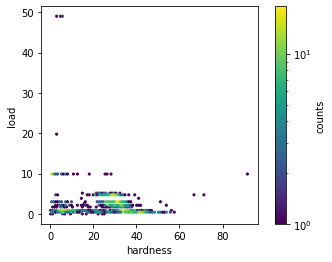

In [27]:
fig, ax = plt.subplots(facecolor="w")
hb = ax.hexbin(df[target_name], df[state_name], bins="log")
plt.ylabel(state_name)
plt.xlabel(target_name)
ax.set_box_aspect(1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

Or via a more traditional x-y scatter plot:

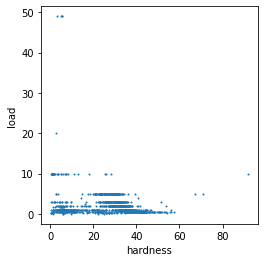

In [28]:
fig, ax = plt.subplots(facecolor="w")
ax.scatter(df[target_name], df[state_name],s=1)
plt.ylabel(state_name)
plt.xlabel(target_name)
ax.set_box_aspect(1)

## MODData

In [29]:
# This instantiates the MODData
data = MODData(
    materials=df["composition"], # you can provide composition objects to MODData
    targets=df[target_name], 
    target_names=[target_name]
)

2022-01-07 01:50:52,663 - modnet - INFO - Loaded CompositionOnlyFeaturizer featurizer.


In [30]:
# Featurization of the moddata
# It will automatically apply composition only featurizers
data.featurize()

2022-01-07 01:50:53,334 - modnet - INFO - Computing features, this can take time...
2022-01-07 01:50:53,335 - modnet - INFO - Applying composition featurizers...
2022-01-07 01:50:53,339 - modnet - INFO - Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x0000023EC43062E0>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonPropert

MultipleFeaturizer: 100%|██████████| 1062/1062 [00:17<00:00, 59.97it/s]


2022-01-07 01:51:19,034 - modnet - INFO - Data has successfully been featurized!


### add hardness data post-hoc

In [31]:
data.df_featurized[state_name] = df[state_name].values

In [32]:
data.df_featurized

,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,AtomicOrbitals|gap_AO,AtomicPackingEfficiency|mean simul. packing efficiency,AtomicPackingEfficiency|mean abs simul. packing efficiency,AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010,...,ValenceOrbital|avg p valence electrons,ValenceOrbital|avg d valence electrons,ValenceOrbital|avg f valence electrons,ValenceOrbital|frac s valence electrons,ValenceOrbital|frac p valence electrons,ValenceOrbital|frac d valence electrons,ValenceOrbital|frac f valence electrons,YangSolidSolution|Yang omega,YangSolidSolution|Yang delta,load
id,,,,,,,,,,,,,,,,,,,,,
id0,3,46,-0.160771,3,46,-0.160771,0.000000,0.011270,0.013120,0.016120,...,0.000000,9.568000,0.336000,0.014527,0.000000,0.952040,0.033433,3.587849e-01,0.050501,0.49
id1,1,39,-0.150727,1,39,-0.150727,0.000000,0.011100,0.011407,0.016120,...,0.000000,9.568000,0.000000,0.015030,0.000000,0.984970,0.000000,3.608379e-01,0.054901,0.49
id2,2,52,-0.226594,2,51,-0.185623,0.040971,0.002165,0.025647,0.061237,...,2.875000,10.000000,3.500000,0.102740,0.157534,0.547945,0.191781,7.854369e+06,0.093935,2.94
id3,2,7,-0.266297,2,7,-0.266297,0.000000,-0.017054,0.023132,0.010758,...,2.571429,0.000000,0.000000,0.437500,0.562500,0.000000,0.000000,6.726751e+06,0.320641,0.98
id4,2,5,-0.136603,2,5,-0.136603,0.000000,-0.016771,0.016771,0.023197,...,1.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,4.767616e+06,0.147942,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id1057,3,23,-0.204634,3,23,-0.204634,0.000000,-0.023942,0.023942,0.029463,...,0.000000,2.666667,0.000000,0.428571,0.000000,0.571429,0.000000,3.221823e+00,0.079674,0.98
id1058,3,74,-0.220603,3,74,-0.220603,0.000000,-0.023617,0.023617,0.029463,...,0.000000,3.333333,9.333333,0.136364,0.000000,0.227273,0.636364,2.098711e+00,0.075997,0.98
id1059,3,76,-0.296791,1,76,-0.191489,0.105302,-0.029887,0.029887,0.049622,...,0.666667,2.000000,4.666667,0.214286,0.071429,0.214286,0.500000,6.616627e-01,0.213724,0.25


### train-test split

In [44]:
from sklearn.model_selection import train_test_split
split = train_test_split(range(df.shape[0]), test_size=0.1, random_state=1234)
train, test = data.split(split)

In [70]:
train.feature_selection(n=-1)

2022-01-07 02:04:21,110 - modnet - INFO - Starting target 1/1: hardness ...
2022-01-07 02:04:21,111 - modnet - INFO - Computing mutual information between features and target...
2022-01-07 02:04:30,343 - modnet - INFO - Computing optimal features...
2022-01-07 02:04:33,639 - modnet - INFO - Selected 50/173 features...
2022-01-07 02:04:35,895 - modnet - INFO - Selected 100/173 features...
2022-01-07 02:04:37,143 - modnet - INFO - Selected 150/173 features...
2022-01-07 02:04:37,302 - modnet - INFO - Done with target 1/1: hardness.
2022-01-07 02:04:37,302 - modnet - INFO - Merging all features...
2022-01-07 02:04:37,303 - modnet - INFO - Done.


In [71]:
state_name in train.optimal_features

True

## MODNet model

In [72]:
model = MODNetModel([[[target_name]]],
                    weights={target_name:1},
                    num_neurons = [[256], [128], [16], [16]],
                    n_feat = 150,
                    act =  "elu"
                   )

### training

In [73]:
model.fit(train,
          val_fraction = 0.1,
          lr = 0.0002,
          batch_size = 64,
          loss = 'mae',
          epochs = 100,
          verbose = 1,
         )

C:\Users\sterg\Miniconda3\envs\modnet\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
14/14 [==============================] - 1s 11ms/step - loss: 23.9045 - mae: 23.9045 - val_loss: 22.5993 - val_mae: 22.5993
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 21.4289 - mae: 21.4289 - val_loss: 20.4993 - val_mae: 20.4993
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 19.3106 - mae: 19.3106 - val_loss: 18.3110 - val_mae: 18.3110
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 16.9091 - mae: 16.9091 - val_loss: 15.6841 - val_mae: 15.6841
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 13.9103 - mae: 13.9103 - val_loss: 12.3490 - val_mae: 12.3490
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 10.1801 - mae: 10.1801 - val_loss: 8.3267 - val_mae: 8.3267
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 7.4886 - mae: 7.4886 - val_loss: 7.7784 - val_mae: 7.7784
Epoch 8/100
14/14 [==============================] - 0s 3ms/

### Predicting

In [74]:
pred = model.predict(test)
pred.head()

,hardness
id207,7.599497
id661,33.518353
id1049,8.367121
id470,34.632599
id485,10.467034


### Model Performance

#### Mean Absolute Error

In [75]:
mae_test = np.absolute(pred.values-test.df_targets.values).mean()
print(f'mae: {mae_test}')

mae: 4.699142387146926


#### Hexagonally-binned parity plot

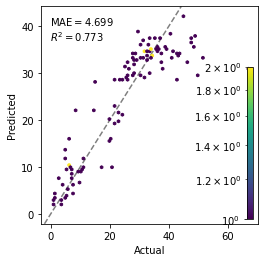

In [76]:
ax = density_hexbin(test.df_targets.values, pred.values)
ax.set_box_aspect(1)

#### Traditional parity plot

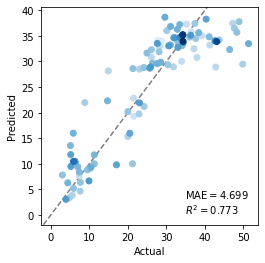

In [77]:
ax = density_scatter(test.df_targets.values.ravel(), pred.values.ravel())
ax.set_box_aspect(1)